In [81]:
import numpy as np
import pandas as pd

from urllib.request import urlretrieve, urlopen

import re
import matplotlib.pyplot as plt
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords

from sklearn.metrics.pairwise import cosine_similarity
import networkx as nx

In [82]:
glove_dict = dict()
f = open('glove.6B.100d.txt', encoding="utf8") # 100차원의 GloVe 벡터를 사용

for line in f:
    word_vector = line.split()
    word = word_vector[0]
    word_vector_arr = np.asarray(word_vector[1:], dtype='float32') # 100개의 값을 가지는 array로 변환
    glove_dict[word] = word_vector_arr
f.close()

In [83]:
# 단어 벡터의 평균으로부터 문장 벡터를 얻는다.
def calculate_sentence_vector(sentence):
    return sum([glove_dict.get(word, zero_vector) 
        for word in sentence])/len(sentence)

# 토큰화 함수
def tokenization(sentences):
    return [word_tokenize(sentence) for sentence in sentences]

# 전처리 함수
def preprocess_sentence(sentence):
    # 영어를 제외한 숫자, 특수 문자 등은 전부 제거. 모든 알파벳은 소문자화
    sentence = [re.sub(r'[^a-zA-z\s]', '', word).lower() for word in sentence]
    # 불용어가 아니면서 단어가 실제로 존재해야 한다.
    return [word for word in sentence if word not in stop_words and word]

# 위 전처리 함수를 모든 문장에 대해서 수행. 이 함수를 호출하면 모든 행에 대해서 수행.
def preprocess_sentences(sentences):
    return [preprocess_sentence(sentence) for sentence in sentences]

# 단어 벡터의 평균으로부터 문장 벡터를 얻는다.
def calculate_sentence_vector(sentence):
    if len(sentence) != 0:
        return sum([glove_dict.get(word, zero_vector) 
                        for word in sentence])/len(sentence)
    else:
        return zero_vector

# 각 문장에 대해서 문장 벡터를 반환
def sentences_to_vectors(sentences):
    return [calculate_sentence_vector(sentence) 
        for sentence in sentences]

def similarity_matrix(sentence_embedding):
    sim_mat = np.zeros([len(sentence_embedding), len(sentence_embedding)])
    for i in range(len(sentence_embedding)):
        for j in range(len(sentence_embedding)):
            sim_mat[i][j] = cosine_similarity(sentence_embedding[i].reshape(1, embedding_dim),
            sentence_embedding[j].reshape(1, embedding_dim))[0,0]
    return sim_mat

def draw_graphs(sim_matrix):
    nx_graph = nx.from_numpy_array(sim_matrix)
    plt.figure(figsize=(10, 10))
    pos = nx.spring_layout(nx_graph)
    nx.draw(nx_graph, with_labels=True, font_weight='bold')
    nx.draw_networkx_edge_labels(nx_graph,pos,font_color='red')
    plt.show()

def calculate_score(sim_matrix):
    nx_graph = nx.from_numpy_array(sim_matrix)
    scores = nx.pagerank(nx_graph)
    return scores

def ranked_sentences(sentences, scores, n=1):
    top_scores = sorted(((scores[i],s) 
        for i,s in enumerate(sentences)), reverse=True)
    top_n_sentences = [sentence 
                        for score,sentence in top_scores[:n]]
    return " ".join(top_n_sentences)


In [84]:
# 불용어 설정
stop_words = stopwords.words('english')

### Data import

In [85]:
data_origin = pd.read_csv('su.csv')
data = data_origin.loc[data_origin['type']=='summary']

data['article_text'] = data['question']

data = data.reset_index()

data['article_id'] = data['index']
data = data[['article_id', 'article_text']]
data.head()

/tmp/ipykernel_31529/559388150.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['article_text'] = data['question']


,article_id,article_text
0,1,"Hello, dog lovers. Does your dog chew up your ..."
1,2,"Good morning, students. You might think that m..."
2,3,"Dear Ms. Green, My name is Donna Williams, a s..."
3,4,One of the most common mistakes made by organi...
4,5,"Environmental hazards include biological, phys..."


In [86]:
data.article_text[0]

'Hello, dog lovers. Does your dog chew up your shoes or bark for no reason at times? Is it hard to control your dog during walks? You no longer have to worry. We’ll help you solve these problems. At the Chester Dog Training Center, we have five professional certified trainers who will improve your dog’s behavior. We also teach you how to understand your dog and what to do when it misbehaves. Leave it to the Chester Dog Training Center. We’ll train your dog to become a well-behaved pet. Call us at 234-555-3647 or visit our website at www.chesterdogs.com.'

In [87]:
data = data[['article_text']]
data['sentences'] = data['article_text'].apply(sent_tokenize)
data

,article_text,sentences
0,"Hello, dog lovers. Does your dog chew up your ...","[Hello, dog lovers., Does your dog chew up you..."
1,"Good morning, students. You might think that m...","[Good morning, students., You might think that..."
2,"Dear Ms. Green, My name is Donna Williams, a s...","[Dear Ms. Green, My name is Donna Williams, a ..."
3,One of the most common mistakes made by organi...,[One of the most common mistakes made by organ...
4,"Environmental hazards include biological, phys...","[Environmental hazards include biological, phy..."
...,...,...
218,"When the weather is nice, most people spend ti...","[When the weather is nice, most people spend t..."
219,Today I’d like you to start by imagining that ...,[Today I’d like you to start by imagining that...
220,One of the rules for success is that it doesn’...,[One of the rules for success is that it doesn...
221,Music is an art that depends on re-creation. W...,"[Music is an art that depends on re-creation.,..."


In [88]:
data['tokenized_sentences'] = data['sentences'].apply(tokenization)
data['tokenized_sentences'] = data['tokenized_sentences'].apply(preprocess_sentences)
data

,article_text,sentences,tokenized_sentences
0,"Hello, dog lovers. Does your dog chew up your ...","[Hello, dog lovers., Does your dog chew up you...","[[hello, dog, lovers], [dog, chew, shoes, bark..."
1,"Good morning, students. You might think that m...","[Good morning, students., You might think that...","[[good, morning, students], [might, think, mat..."
2,"Dear Ms. Green, My name is Donna Williams, a s...","[Dear Ms. Green, My name is Donna Williams, a ...","[[dear, ms, green, name, donna, williams, scie..."
3,One of the most common mistakes made by organi...,[One of the most common mistakes made by organ...,"[[one, common, mistakes, made, organizations, ..."
4,"Environmental hazards include biological, phys...","[Environmental hazards include biological, phy...","[[environmental, hazards, include, biological,..."
...,...,...,...
218,"When the weather is nice, most people spend ti...","[When the weather is nice, most people spend t...","[[weather, nice, people, spend, time, outdoors..."
219,Today I’d like you to start by imagining that ...,[Today I’d like you to start by imagining that...,"[[today, like, start, imagining, suddenly, wri..."
220,One of the rules for success is that it doesn’...,[One of the rules for success is that it doesn...,"[[one, rules, success, matter, coming, matters..."
221,Music is an art that depends on re-creation. W...,"[Music is an art that depends on re-creation.,...","[[music, art, depends, recreation], [look, pai..."


In [89]:
embedding_dim = 100
zero_vector = np.zeros(embedding_dim)


In [90]:
data['SentenceEmbedding'] = data['tokenized_sentences'].apply(sentences_to_vectors)
data[['SentenceEmbedding']]


,SentenceEmbedding
0,"[[0.3680233, 0.43280998, 0.48545334, -0.579228..."
1,"[[0.155307, 0.19599998, -0.09638882, -0.102606..."
2,"[[0.078964554, 0.19838363, 0.085096, -0.295707..."
3,"[[-0.21025237, 0.27325875, -0.0065495954, 0.01..."
4,"[[0.08481055, 0.21080644, 0.116177335, 0.05856..."
...,...
218,"[[-0.23337765, 0.28582785, 0.2697871, -0.11774..."
219,"[[0.0110680405, 0.31001905, 0.4228861, -0.0698..."
220,"[[-0.0028667194, 0.041411426, 0.6925815, -0.17..."
221,"[[0.025620492, 0.6139825, 0.16198, 0.12412511,..."


In [91]:
data['SimMatrix'] = data['SentenceEmbedding'].apply(similarity_matrix)
data['SimMatrix']


0      [[1.0, 0.6432767510414124, 0.6301954388618469,...
1      [[1.0000001192092896, 0.7388592958450317, 0.76...
2      [[1.0, 0.7055472731590271, 0.6946079730987549,...
3      [[0.9999999403953552, 0.9542273879051208, 0.95...
4      [[0.9999999403953552, 0.8369238972663879, 0.87...
                             ...                        
218    [[1.0, 0.793689489364624, 0.7909477353096008, ...
219    [[1.0, 0.805306077003479, 0.8312667608261108, ...
220    [[0.9999999403953552, 0.8993074893951416, 0.84...
221    [[1.0, 0.7758115530014038, 0.8058180212974548,...
222    [[1.0, 0.7664497494697571, 0.6207472085952759,...
Name: SimMatrix, Length: 223, dtype: object

In [92]:
print('두번째 샘플의 문장 개수 :',len(data['tokenized_sentences'][1]))
print('두번째 샘플의 문장 벡터가 모인 문장 행렬의 크기(shape) :',np.shape(data['SentenceEmbedding'][1]))
print('두번째 샘플의 유사도 행렬의 크기(shape) :',data['SimMatrix'][1].shape)


두번째 샘플의 문장 개수 : 15
두번째 샘플의 문장 벡터가 모인 문장 행렬의 크기(shape) : (15, 100)
두번째 샘플의 유사도 행렬의 크기(shape) : (15, 15)


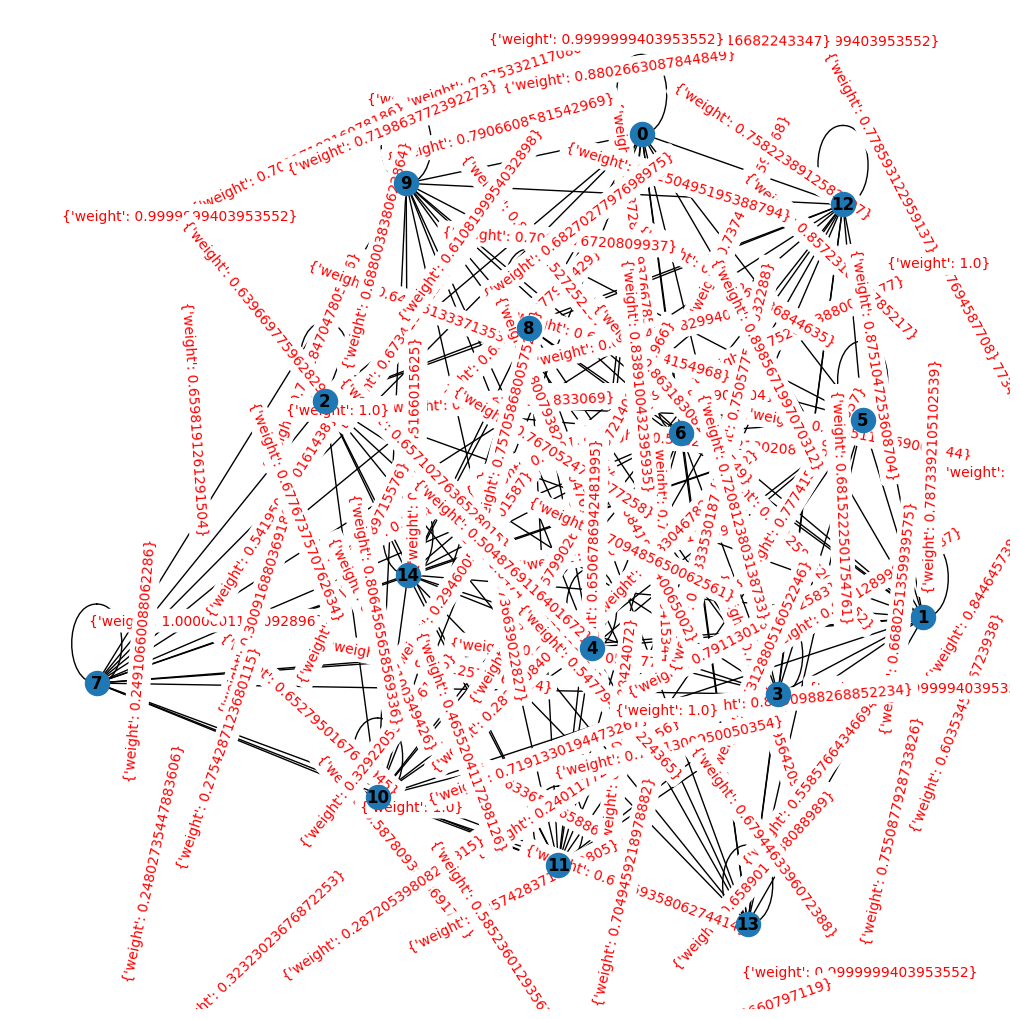

In [93]:
draw_graphs(data['SimMatrix'][1])


In [94]:
data['score'] = data['SimMatrix'].apply(calculate_score)
data[['SimMatrix', 'score']]


,SimMatrix,score
0,"[[1.0, 0.6432767510414124, 0.6301954388618469,...","{0: 0.0869772872876298, 1: 0.10021051048000523..."
1,"[[1.0000001192092896, 0.7388592958450317, 0.76...","{0: 0.06594348878622257, 1: 0.0691189943263333..."
2,"[[1.0, 0.7055472731590271, 0.6946079730987549,...","{0: 0.12670100574316523, 1: 0.1286807739785727..."
3,"[[0.9999999403953552, 0.9542273879051208, 0.95...","{0: 0.17137280277790326, 1: 0.1690934838265062..."
4,"[[0.9999999403953552, 0.8369238972663879, 0.87...","{0: 0.16716112771769434, 1: 0.1666407047643358..."
...,...,...
218,"[[1.0, 0.793689489364624, 0.7909477353096008, ...","{0: 0.14368475336850672, 1: 0.1381590566613787..."
219,"[[1.0, 0.805306077003479, 0.8312667608261108, ...","{0: 0.11427439398287434, 1: 0.1028994677029264..."
220,"[[0.9999999403953552, 0.8993074893951416, 0.84...","{0: 0.11451502283480877, 1: 0.1150349004625971..."
221,"[[1.0, 0.7758115530014038, 0.8058180212974548,...","{0: 0.1094123880549695, 1: 0.11327747125909579..."


In [95]:
data['score'][1]


{0: 0.06594348878622257,
 1: 0.06911899432633334,
 2: 0.06994736684422234,
 3: 0.0704894902543264,
 4: 0.07112892651841503,
 5: 0.07317846817527598,
 6: 0.0740501477695002,
 7: 0.03974556645224302,
 8: 0.07265797326356427,
 9: 0.06559674203331797,
 10: 0.06575448231678069,
 11: 0.06929377799377606,
 12: 0.06143629979988249,
 13: 0.0616487212626533,
 14: 0.07000955420348641}

In [96]:
data['summary'] = data.apply(lambda x: 
                            ranked_sentences(x.sentences, 
                            x.score), axis=1)


In [ ]:
for i in range(0, len(data)):
  print(i+1,'번 문서')
  print('원문 :',data.loc[i].article_text)
  print('')
  print('요약 :',data.loc[i].summary)
  print('')


In [98]:
data

,article_text,sentences,tokenized_sentences,SentenceEmbedding,SimMatrix,score,summary
0,"Hello, dog lovers. Does your dog chew up your ...","[Hello, dog lovers., Does your dog chew up you...","[[hello, dog, lovers], [dog, chew, shoes, bark...","[[0.3680233, 0.43280998, 0.48545334, -0.579228...","[[1.0, 0.6432767510414124, 0.6301954388618469,...","{0: 0.0869772872876298, 1: 0.10021051048000523...",Is it hard to control your dog during walks?
1,"Good morning, students. You might think that m...","[Good morning, students., You might think that...","[[good, morning, students], [might, think, mat...","[[0.155307, 0.19599998, -0.09638882, -0.102606...","[[1.0000001192092896, 0.7388592958450317, 0.76...","{0: 0.06594348878622257, 1: 0.0691189943263333...","Second, painting frequently uses math concepts..."
2,"Dear Ms. Green, My name is Donna Williams, a s...","[Dear Ms. Green, My name is Donna Williams, a ...","[[dear, ms, green, name, donna, williams, scie...","[[0.078964554, 0.19838363, 0.085096, -0.295707...","[[1.0, 0.7055472731590271, 0.6946079730987549,...","{0: 0.12670100574316523, 1: 0.1286807739785727...",I am sure the lecture will help our teachers m...
3,One of the most common mistakes made by organi...,[One of the most common mistakes made by organ...,"[[one, common, mistakes, made, organizations, ...","[[-0.21025237, 0.27325875, -0.0065495954, 0.01...","[[0.9999999403953552, 0.9542273879051208, 0.95...","{0: 0.17137280277790326, 1: 0.1690934838265062...",One of the most common mistakes made by organi...
4,"Environmental hazards include biological, phys...","[Environmental hazards include biological, phy...","[[environmental, hazards, include, biological,...","[[0.08481055, 0.21080644, 0.116177335, 0.05856...","[[0.9999999403953552, 0.8369238972663879, 0.87...","{0: 0.16716112771769434, 1: 0.1666407047643358...","In many countries, the fact that some environm..."
...,...,...,...,...,...,...,...
218,"When the weather is nice, most people spend ti...","[When the weather is nice, most people spend t...","[[weather, nice, people, spend, time, outdoors...","[[-0.23337765, 0.28582785, 0.2697871, -0.11774...","[[1.0, 0.793689489364624, 0.7909477353096008, ...","{0: 0.14368475336850672, 1: 0.1381590566613787...","Otherwise, a low area is a relatively safe pla..."
219,Today I’d like you to start by imagining that ...,[Today I’d like you to start by imagining that...,"[[today, like, start, imagining, suddenly, wri...","[[0.0110680405, 0.31001905, 0.4228861, -0.0698...","[[1.0, 0.805306077003479, 0.8312667608261108, ...","{0: 0.11427439398287434, 1: 0.1028994677029264...","With the invention of writing, humans could ho..."
220,One of the rules for success is that it doesn’...,[One of the rules for success is that it doesn...,"[[one, rules, success, matter, coming, matters...","[[-0.0028667194, 0.041411426, 0.6925815, -0.17...","[[0.9999999403953552, 0.8993074893951416, 0.84...","{0: 0.11451502283480877, 1: 0.1150349004625971...","Instead, think about the future and where you ..."
221,Music is an art that depends on re-creation. W...,"[Music is an art that depends on re-creation.,...","[[music, art, depends, recreation], [look, pai...","[[0.025620492, 0.6139825, 0.16198, 0.12412511,...","[[1.0, 0.7758115530014038, 0.8058180212974548,...","{0: 0.1094123880549695, 1: 0.11327747125909579...","They can’t play several instruments at once, a..."


### 데이터 저장

In [99]:
data_origin = pd.read_csv('su.csv')

data_origin = data_origin.loc[data_origin['type']=='summary']

data_origin['pred_summary']= list(data['summary'])


In [100]:
data_origin['question'][0]

'Hello, dog lovers. Does your dog chew up your shoes or bark for no reason at times? Is it hard to control your dog during walks? You no longer have to worry. We’ll help you solve these problems. At the Chester Dog Training Center, we have five professional certified trainers who will improve your dog’s behavior. We also teach you how to understand your dog and what to do when it misbehaves. Leave it to the Chester Dog Training Center. We’ll train your dog to become a well-behaved pet. Call us at 234-555-3647 or visit our website at www.chesterdogs.com.'

In [101]:
data_origin['pred_summary'][0]

'Is it hard to control your dog during walks?'

In [102]:
data_origin

,index,question,answer,1,2,3,4,5,type,original_index,year,pred_summary
0,1,"Hello, dog lovers. Does your dog chew up your ...",5,To explain how to get a trainer license,To announce the relocation of the animal hospital,to introduce the newly released dog food,to guide you through the adoption process,To promote the dog training center,summary,1,2022,Is it hard to control your dog during walks?
1,2,"Good morning, students. You might think that m...",3,effects of incorporating painting into math ed...,mathematical analysis of the art industry’s gr...,application of mathematics in different types ...,historical review of important concepts in the...,challenges of harmonizing mathematics and art,summary,16,2022,"Second, painting frequently uses math concepts..."
2,3,"Dear Ms. Green, My name is Donna Williams, a s...",2,to encourage participation in the Science Educ...,to ask for a special lecture at the science te...,to announce the plan to hire a science teacher,to request the development of a science educat...,To guide through the changes in the schedule o...,summary,18,2022,I am sure the lecture will help our teachers m...
3,4,One of the most common mistakes made by organi...,3,It is necessary to develop and operate social ...,Companies should establish business goals by r...,"When using social media, companies should base...","When promoting a product on social media, comp...",Social media should be actively used to gather...,summary,20,2022,One of the most common mistakes made by organi...
4,5,"Environmental hazards include biological, phys...",1,Social response is needed for harmful environm...,It is desirable to provide appropriate compens...,Action beyond moral condemnation is required f...,In order to solve the environmental pollution ...,The problem of air pollution can be solved thr...,summary,22,2022,"In many countries, the fact that some environm..."
...,...,...,...,...,...,...,...,...,...,...,...,...
345,346,"When the weather is nice, most people spend ti...",4,check the expiration date of your passport,Security scan procedures should be followed,It's better to book a flight in advance,have to arrive at the airport early enough,It is necessary to check the customs declarati...,summary,5,2014_06_B,"Otherwise, a low area is a relatively safe pla..."
346,347,Today I’d like you to start by imagining that ...,2,to promote a new children’s hospital,to advise parents on their children’s welfare,to warn people of an unknown disease,to notify children of seat belt safety in cars,to give tips on how to feed family pets,summary,21,2014_06_B,"With the invention of writing, humans could ho..."
347,348,One of the rules for success is that it doesn’...,4,Don't suppress your imagination.,Make the most of your potential.,Set a realistic goal clearly.,"Don't stick to the past, focus on the future.",Prioritize work from past experiences.,summary,23,2014_06_B,"Instead, think about the future and where you ..."
348,349,Music is an art that depends on re-creation. W...,1,Music is brought to life by performers.,Listeners’ appreciation completes music.,Composers are the genuine creators of music.,Composers rarely create music out of nothing.,Music depends on the audience for interpretation.,summary,24,2014_06_B,"They can’t play several instruments at once, a..."


In [103]:
data_origin['pred_summary']

0           Is it hard to control your dog during walks?
1      Second, painting frequently uses math concepts...
2      I am sure the lecture will help our teachers m...
3      One of the most common mistakes made by organi...
4      In many countries, the fact that some environm...
                             ...                        
345    Otherwise, a low area is a relatively safe pla...
346    With the invention of writing, humans could ho...
347    Instead, think about the future and where you ...
348    They can’t play several instruments at once, a...
349    The National Park Service says 1,825 Burmese p...
Name: pred_summary, Length: 223, dtype: object

In [104]:
data_result = data_origin.reset_index(drop=True)

In [105]:
data_result = data_result[['question', 'answer', '1', '2', '3', '4', '5', 'original_index', 'year','pred_summary']]

In [106]:
data_result

,question,answer,1,2,3,4,5,original_index,year,pred_summary
0,"Hello, dog lovers. Does your dog chew up your ...",5,To explain how to get a trainer license,To announce the relocation of the animal hospital,to introduce the newly released dog food,to guide you through the adoption process,To promote the dog training center,1,2022,Is it hard to control your dog during walks?
1,"Good morning, students. You might think that m...",3,effects of incorporating painting into math ed...,mathematical analysis of the art industry’s gr...,application of mathematics in different types ...,historical review of important concepts in the...,challenges of harmonizing mathematics and art,16,2022,"Second, painting frequently uses math concepts..."
2,"Dear Ms. Green, My name is Donna Williams, a s...",2,to encourage participation in the Science Educ...,to ask for a special lecture at the science te...,to announce the plan to hire a science teacher,to request the development of a science educat...,To guide through the changes in the schedule o...,18,2022,I am sure the lecture will help our teachers m...
3,One of the most common mistakes made by organi...,3,It is necessary to develop and operate social ...,Companies should establish business goals by r...,"When using social media, companies should base...","When promoting a product on social media, comp...",Social media should be actively used to gather...,20,2022,One of the most common mistakes made by organi...
4,"Environmental hazards include biological, phys...",1,Social response is needed for harmful environm...,It is desirable to provide appropriate compens...,Action beyond moral condemnation is required f...,In order to solve the environmental pollution ...,The problem of air pollution can be solved thr...,22,2022,"In many countries, the fact that some environm..."
...,...,...,...,...,...,...,...,...,...,...
218,"When the weather is nice, most people spend ti...",4,check the expiration date of your passport,Security scan procedures should be followed,It's better to book a flight in advance,have to arrive at the airport early enough,It is necessary to check the customs declarati...,5,2014_06_B,"Otherwise, a low area is a relatively safe pla..."
219,Today I’d like you to start by imagining that ...,2,to promote a new children’s hospital,to advise parents on their children’s welfare,to warn people of an unknown disease,to notify children of seat belt safety in cars,to give tips on how to feed family pets,21,2014_06_B,"With the invention of writing, humans could ho..."
220,One of the rules for success is that it doesn’...,4,Don't suppress your imagination.,Make the most of your potential.,Set a realistic goal clearly.,"Don't stick to the past, focus on the future.",Prioritize work from past experiences.,23,2014_06_B,"Instead, think about the future and where you ..."
221,Music is an art that depends on re-creation. W...,1,Music is brought to life by performers.,Listeners’ appreciation completes music.,Composers are the genuine creators of music.,Composers rarely create music out of nothing.,Music depends on the audience for interpretation.,24,2014_06_B,"They can’t play several instruments at once, a..."


In [107]:
data_result.to_csv('result.csv')